In [1]:
# Import all packages 
import numpy as np
import pandas as pd
import os as os
import seaborn as sns
import sys
import scipy
from scipy.integrate import odeint
import matplotlib.pyplot as plt 
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.transforms import Bbox
from skimage import data, exposure, img_as_float
from PIL import Image
from matplotlib.backends.backend_pdf import PdfPages
import datetime
from tifffile import imread
import glob
import cv2
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar



# Make plots look good 
%config InlineBackend.figure_format = 'svg'
sns.set_style("whitegrid")
sns.set_context("paper")

In [445]:
def flatten(xss):
    return [x for xs in xss for x in xs]

In [2]:
# Get current directory
cwd = os.getcwd()
cwd = cwd.split('Paper')[0]
cwd = '/Volumes/GoogleDrive-101945757574252901453/My Drive/Hueros_Shared/'
print('Path to Paper folder: ', cwd)

Path to Paper folder:  /Volumes/GoogleDrive-101945757574252901453/My Drive/Hueros_Shared/


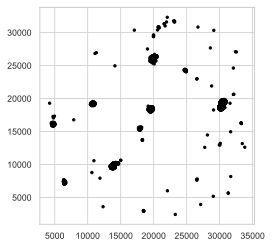

In [3]:

path_im = cwd +"Paper/data/processed/RAR023/Day8/PositionTable/PositionTable_binary_20210422_012947_624__Plate20210422_STR_colonies_Phalloidin_IF_Ki67_day8_Well03_ChannelA647,GFP,DAPI_Seq0002_Stitched.txt"
data = pd.read_csv(path_im, sep=",")
fig = plt.figure()
ax = fig.add_subplot(111, aspect=1) 
plt.plot(data.X, data.Y, 'k.')

path_to_save = cwd + '/Paper/outputs/figures/figure1/figure1_B.pdf'
# plt.savefig(path_to_save)

Load data: 
Read 16 files!
Reading files:
               Day Day2
                            Read 12 files!
               Day Day4
                            Read 8 files!
               Day Day6
                            Read 11 files!
               Day Day8
                            Read 9 files!
               Day Day10
                            Read 11 files!


Text(0.5, 0.98, 'GrowthRate')

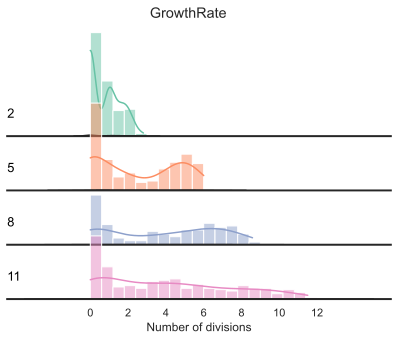

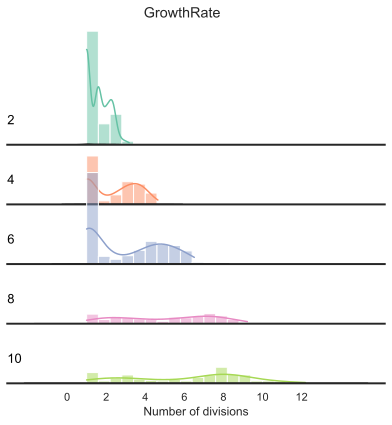

In [34]:

#---------------------------------------------
#Load Data
#---------------------------------------------
print("Load data: ")
#put your path here
path_to_table =  cwd+'Paper/data/processed/RAR014/ColonySelector_quantification/Colony_count_quantified/FinalTable/'

#Get all mask files
all_txt_files = list(filter(lambda x: x.endswith('.txt'), os.listdir(path_to_table)))
all_txt_files = sorted(all_txt_files)

# set up iniitial df

df = pd.read_csv(path_to_table+all_txt_files[0], sep=",")
df['ID'] = 1
df['Day'] = 8
for i in range(1,len(all_txt_files)):
    
    if i < 4:
        day = 8
    elif i < 7:
        day = 2
    elif i < 11:
        day = 5
    elif i < 15:
        day = 11    
        
    df_hold = pd.read_csv(path_to_table+all_txt_files[i], sep=",")
    df_hold['ID'] = i+1
    df_hold['Day'] = day
    df = pd.concat([df,df_hold])
    
# Calculate any metric you want on the dataframe
df['Colony_area_per_number_of_cells'] = df.Colony_area/df.number_of_cells

print('Read ' + str(len(all_txt_files)) + ' files!')

#---------------------------------------------
#Plot Data
#---------------------------------------------

# Remove clones with less than # cells
df_all = df[df.number_of_cells >0]
# df_all = df[df.Day >2]
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})

df_all['GrowthRate'] = np.log2(df_all.number_of_cells)
palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(df_all, palette=palette, row="Day", hue="Day", aspect=5, height=1.2)
g.map_dataframe(sns.histplot, x="GrowthRate", binwidth=.6, kde=True)


g.map_dataframe(sns.kdeplot, x="GrowthRate", color='black')
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "GrowthRate")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="Number of divisions")
arr = np.array([0,2,4,6,8,10,12])
plt.xticks(arr)
g.despine( left=True)
plt.suptitle('GrowthRate', y=0.98)


path_to_save = cwd + '/Paper/outputs/figures/figure1/figure1_C.pdf'
# plt.savefig(path_to_save)



#---------------------------------------------
# Replicate
#---------------------------------------------

#put your path here
Days = ("Day2","Day4","Day6","Day8","Day10")
Days_n = [2,4,6,8,10]
path_to_experiment = '/Volumes/4TDATA_RAR/RAR/Shaffer_Scope/RAR023/'
path_to_table = "/Tables/"

# Get all FinalTable... .txt files for each day 
final_paths = [path_to_experiment + s + path_to_table for s in Days]

print("Reading files:")

df = pd.DataFrame()
cnt = 0
for i in final_paths:
    
    print("               Day " + Days[cnt])
    #Get all mask files
    all_txt_files = list(filter(lambda x: x.startswith('FinalTable'), os.listdir(i)))
    all_txt_files = sorted(all_txt_files)
    cnt += 1 
    
    for j in range(0,len(all_txt_files)): 
        
        df_hold = pd.read_csv(i + all_txt_files[j], sep=",")
        df_hold['well_ID'] = j+1
        df_hold['Day'] = Days_n[cnt-1]
        df = pd.concat([df,df_hold])

    print('                            Read ' + str(len(all_txt_files)) + ' files!')
    
# Calculate any metric you want on the dataframe
df['Colony_area_per_number_of_cells'] = df.Colony_area/df.number_of_cells


#---------------------------------------------
#Plot Data
#---------------------------------------------

# Remove clones with less than # cells
df_all2 = df[df.number_of_cells >0]

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})

df_all2['GrowthRate'] = np.log2(df_all2.number_of_cells+1)
palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(df_all2, palette=palette, row="Day", hue="Day", aspect=5, height=1.2)
g.map_dataframe(sns.histplot, x="GrowthRate", binwidth=.6, kde=True)


g.map_dataframe(sns.kdeplot, x="GrowthRate", color='black')
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "GrowthRate")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="Number of divisions")
arr = np.array([0,2,4,6,8,10,12])
plt.xticks(arr)
g.despine( left=True)
plt.suptitle('GrowthRate', y=0.98)


# path_to_save = cwd + '/Paper/outputs/figures/figure1/figure1_C_replicate.pdf'
# # plt.savefig(path_to_save)




In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
from scipy.stats import skew, kurtosis, entropy
from gap_statistic import OptimalK

def compute_metrics(data):
    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm.fit(data.reshape(-1, 1))

    means = gmm.means_.flatten()
    std_devs = np.sqrt(gmm.covariances_).flatten()
    weights = gmm.weights_
    labels = gmm.predict(data.reshape(-1, 1))

    # AIC and BIC
    aic = gmm.aic(data.reshape(-1, 1))
    bic = gmm.bic(data.reshape(-1, 1))

    # Silhouette Score
    silhouette = silhouette_score(data.reshape(-1, 1), labels)
    
    # Calculate separation metric
    separation = np.abs(means[0] - means[1]) / np.sqrt((std_devs[0]**2 + std_devs[1]**2) / 2)
    
    # Bimodality Coefficient
    skewness = skew(data)
    kurt = kurtosis(data, fisher=True)  # Fisher's kurtosis
    BC = (skewness**2 + 1) / (kurt + 3 * (2 - 1))

    # Entropy
    pdf = np.exp(gmm.score_samples(data.reshape(-1, 1)))
    ent = entropy(pdf)

    # Hartigan's Dip Test (using a placeholder value, actual test requires external library)
    dip_test_p_value = 0.01  # Placeholder for Hartigan's Dip Test p-value

    # Gap Statistic
    optimalK = OptimalK(parallel_backend='joblib')
    n_clusters = optimalK(data.reshape(-1, 1), cluster_array=np.arange(1, 6))
    gap_stat = optimalK.gap_df.iloc[n_clusters-1]['gap_value']

    return {
        "gmm": gmm,
        "means": means,
        "std_devs": std_devs,
        "weights": weights,
        "aic": aic,
        "bic": bic,
        "BC": BC,
        "silhouette": silhouette,
        "separation": separation,
        "entropy": ent,
        "dip_test_p_value": dip_test_p_value,
        "gap_stat": gap_stat
    }

def visualize_metrics(data, metrics, **kwargs):
    fig, axs = plt.subplots( 2, figsize=(5, 10))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    # Histogram with Gaussian fits
    x = np.linspace(min(data), max(data), 1000)
    gmm_pdf = np.exp(metrics['gmm'].score_samples(x.reshape(-1, 1)))
    axs[0].hist(data, density=True, alpha=0.4, color='b', label='Data')
    
    axs[0].plot(x, gmm_pdf, label='Fitted Gaussian Mixture', color='red', linewidth=2, alpha=0.4)
    
    for mean, std, weight in zip(metrics["means"], metrics["std_devs"], metrics["weights"]):
        y = weight * (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-(x - mean)**2 / (2 * std**2))
        axs[ 0].plot(x, y, linestyle='--', label=f'Gaussian(mean={mean:.2f}, std={std:.2f}, weight={weight:.2f})')
    axs[0].set_title('Histogram with Gaussian Fits')
    axs[ 0].legend(loc=[1.01,0.5], framealpha=0.0)
    
    # Bimodality Coefficient
    axs[1].axhline(y=5/9, color='gray', linestyle='--', label='Bimodality Threshold (5/9)')
    axs[1].axhline(y=1/3, color='black', linestyle=':', label='Unimodality Threshold (1/3)')
    
    axs[ 1].bar(['Bimodality Coefficient'], [metrics['BC']], color=['blue'])


    # Silhouette Score
    axs[ 1].bar(['Silhouette'], [metrics['silhouette']], color=['#A890F0'])

    # Stacked bar plot for Gaussian weights
    df_hold = pd.DataFrame({
    'Distribution': ['Gaussian 1','Gaussian 2'],
    'Metric': ['Gaussian','Gaussian'],
    'Weight': metrics['weights']})
    
    axs[ 1].bar(['Gaussian'], [metrics['weights'][0]], color='#fdaa48', label='Gaussian 1')
    axs[ 1].bar(['Gaussian'], [metrics['weights'][1]], color='#6890F0', label='Gaussian 2', bottom=metrics['weights'][0])
    axs[ 1].set_xlabel('Metric')
    axs[ 1].set_title('Score')
    axs[ 1].legend(loc=[1.01,0.5], framealpha=0.0)
    
    
    means = metrics["means"]
    std_devs = metrics["std_devs"]
    weights = metrics["weights"]
    separation = metrics["separation"]
    BC = metrics["BC"]
    AIC = metrics["aic"]
    BIC = metrics["bic"]

    # Annotate separation metric and bimodality coefficient
    annotation_text = (f'Separation Metric: {separation:.3f}\n'
                       f'Bimodality Coefficient: {BC:.3f}\n'
                       f'AIC: {AIC:.3f}\n'
                       f'BIC: {BIC:.3f}')
    axs[0].text(1.01, .4, annotation_text, transform=axs[0].transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
    
    

    plt.show()



# # Run on Data
# df_sub = df_all[df_all['Day'] == 11]
# metrics = compute_metrics(np.array(df_sub.GrowthRate))
# visualize_metrics(np.array(df_sub.GrowthRate), metrics)

day = 2


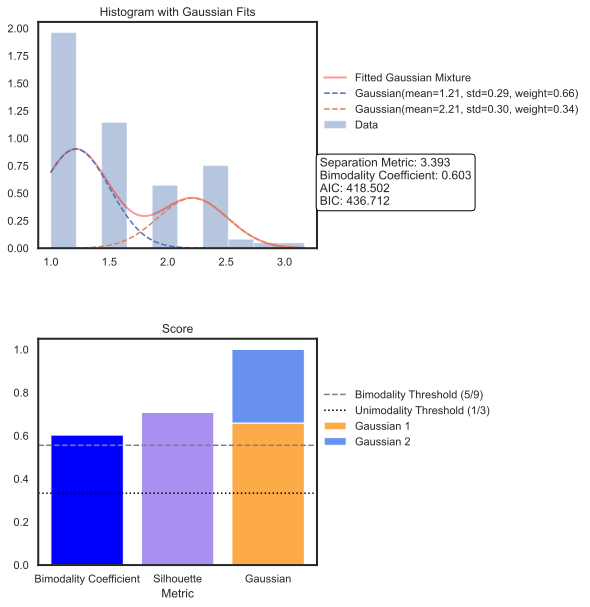

day = 4


<Figure size 432x288 with 0 Axes>

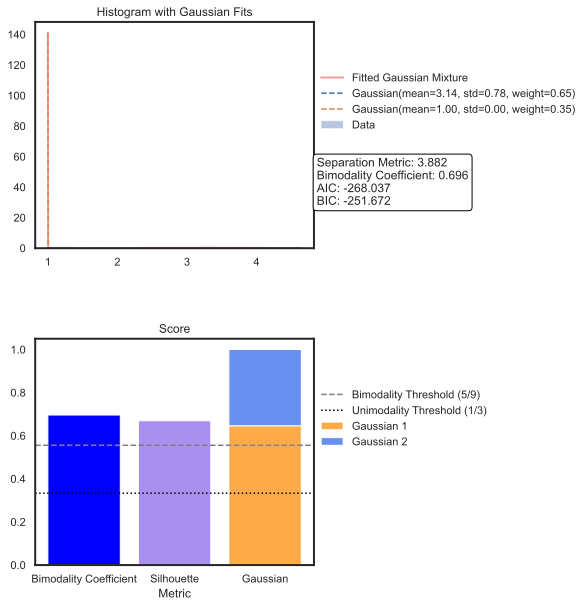

day = 6


<Figure size 432x288 with 0 Axes>

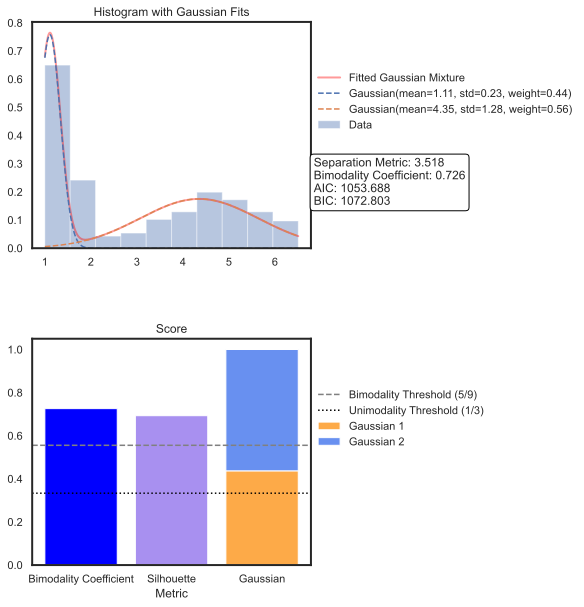

day = 8


<Figure size 432x288 with 0 Axes>

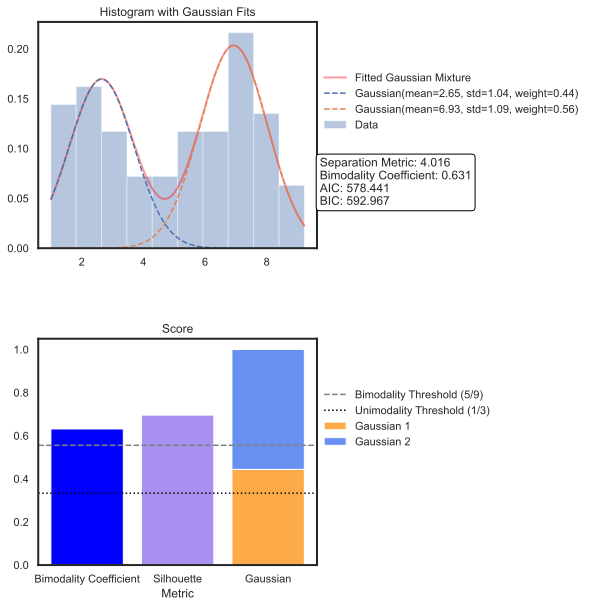

day = 10


<Figure size 432x288 with 0 Axes>

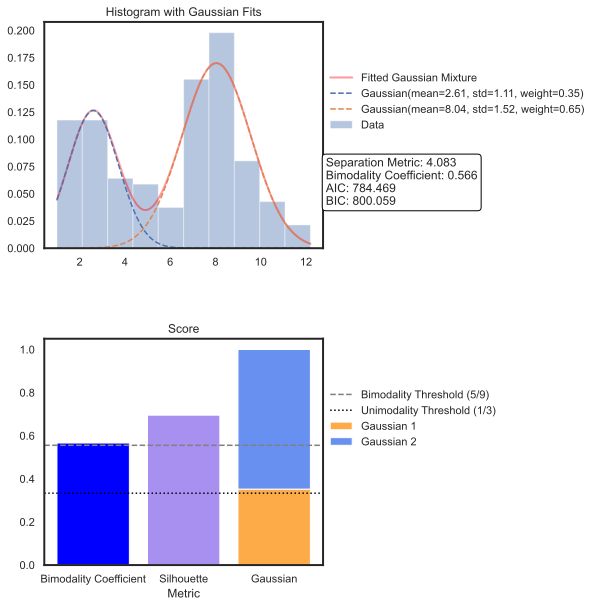

<Figure size 432x288 with 0 Axes>

In [68]:
from matplotlib.backends.backend_pdf import PdfPages

df_plot =df_all2
days_ = df_plot.Day.unique()

output_path = ''
with PdfPages('output.pdf') as pdf:
    for day in days_:
        print(f'{day = }') 

        # Run on Data
        df_sub = df_plot[df_plot['Day'] == day]


        metrics = compute_metrics(np.array(df_sub.GrowthRate))
        visualize_metrics(np.array(df_sub.GrowthRate), metrics)

        results = metrics
        pdf.savefig( bbox_inches='tight') 

        plt.figure(day)



In [32]:
# Create Test data to check everything is working

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Set seed for reproducibility
np.random.seed(42)

# Generate example data
n_samples_per_day = 1000
days = [ 2,  5, 8]

data = []
number_of_cells_ = []
days_ = []


for day in days:
    # Simulate bimodal distributions for different days
    if day % 2 == 0:  # Even days have one distribution
        number_of_cells = np.concatenate([
            np.random.poisson(lam=400, size=n_samples_per_day // 2),
            np.random.poisson(lam=400, size=n_samples_per_day // 2)
        ])
    else:  # Odd days have another distribution
        number_of_cells = np.concatenate([
            np.random.poisson(lam=400, size=n_samples_per_day // 2),
            np.random.poisson(lam=400, size=n_samples_per_day // 2)
        ])
        
    days_.append([day]*len(number_of_cells))
    number_of_cells_.append(number_of_cells)
    
def flatten(xss):
    return [x for xs in xss for x in xs]

# Create DataFrame
df_all = pd.DataFrame({'Day':flatten(days_),'number_of_cells': flatten(number_of_cells_)})

# Compute the GrowthRate
df_all['GrowthRate'] = np.log2(df_all['number_of_cells'] + 1)  # Adding 1 to avoid log(0)

# Display the first few rows of the dataset
print(df_all.head())

# The provided code will be used with this dataset.

   Day  number_of_cells  GrowthRate
0    2              393    8.622052
1    2              414    8.696968
2    2              377    8.562242
3    2              406    8.668885
4    2              422    8.724514


array([ 8,  2,  5, 11])

/Users/raul/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/Users/raul/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/Users/raul/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/Users/raul/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


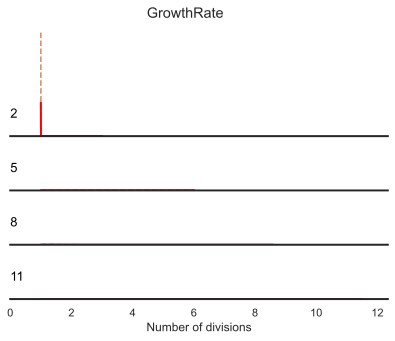

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

# Set up the plotting environment
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth': 2})

# Data preprocessing
df_all['GrowthRate'] = np.log2(df_all['number_of_cells'] + 1)  # Avoid log(0)
palette = sns.color_palette("Set2", 12)

# Create a FacetGrid for histograms
g = sns.FacetGrid(df_all, palette=palette, row="Day", hue="Day", aspect=5, height=1.2)

# Function to fit and plot Gaussian
def plot_gaussian_fit(data, **kwargs):
    # Fit the Gaussian Mixture Model
    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm.fit(data[['GrowthRate']])
    
    # Extract the means and covariances of the fitted Gaussians
    means = gmm.means_.flatten()
    std_devs = np.sqrt(gmm.covariances_).flatten()
    
    # Create a range of values for plotting
    x = np.linspace(min(data['GrowthRate']), max(data['GrowthRate']), 1000)
    pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))
    
    # Normalize the Gaussian Mixture PDF
    pdf /= np.trapz(pdf, x)  # Ensures the area under the PDF is 1
    
    # Plot the individual Gaussians
    for mean, std in zip(means, std_devs):
        y = 1/(std * np.sqrt(2 * np.pi)) * np.exp(-(x - mean)**2 / (2 * std**2))
        y /= np.trapz(y, x)  # Normalizes the area under each Gaussian
        plt.plot(x, y, label=f'Gaussian(mean={mean:.2f}, std={std:.2f})', linestyle='--')

    # Plot the combined Gaussian Mixture
    plt.plot(x, pdf, label='Fitted Gaussian Mixture', color='red', linewidth=2)

# Plot the histograms with KDE
g.map_dataframe(sns.histplot, x="GrowthRate", binwidth=.6, kde=True, stat='density')

# Map the Gaussian fit function to each subset
g.map_dataframe(plot_gaussian_fit)

# Adjust aesthetics
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "GrowthRate")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="Number of divisions")
arr = np.array([0, 2, 4, 6, 8, 10, 12])
plt.xticks(arr)
g.despine(left=True)
plt.suptitle('GrowthRate', y=0.98)

# Show the plot
plt.show()

In [67]:
from cellori import Cellori
import pandas as pd
import glob


# all import statements
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import tifffile
import pandas as pd
import seaborn as sns
import time
import os
import glob
from skimage import measure
import skimage.measure as skmeas
from PyQt5 import QtCore, QtGui, QtWidgets

from statannot import add_stat_annotation

Image.MAX_IMAGE_PIXELS = None

%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [203]:
#Third Replicate 


#Path to files from Step1
main_path = "/Volumes/GoogleDrive-101945757574252901453/My Drive/Hueros_Shared/Paper/data/processed/RAR046/20220412_Cas12_rep3/Cellori_clean"
#"/Volumes/4TDATA_RAR/RAR/Shaffer_Scope/20220930_Cas12/Cellori_clean"
paths_to_all_pik = glob.glob(main_path+"/*.pkl")



colony_all_files = []
colony_hold = []
colony_name = []
colony_well = []
colony_gRNA = []

for i in paths_to_all_pik:
    #print("         " + i )
    name_gRNA = i.split("/")[-1].split('.')[0].split('Plate')[-1][0:9]#

    
    name_compare = i.split("/")[-1].split('.')[0].split('Plate')[-1][0:4]#
    well_compare = i.split("/")[-1].split('.')[0].split('clean')[-1][15:40]#[0:4]#
        
    if i.split("/")[-1].split('.')[0].split('Plate')[-1][0:5] != 'Rosa23':
    #name_compare = 'Rosa1'

        df_points = pd.read_pickle(i)


        #Get all colony sizes
        for k,m in enumerate(np.unique(df_points['colonyID'])):
            if m != -1:
                colony_hold.append(len(df_points.loc[df_points['colonyID'] == m]))
                colony_name.append(name_compare)
                colony_well.append(well_compare)
                colony_gRNA.append(name_gRNA)

    #     flat_list = [item for sublist in colony_hold for item in sublist]             
        colony_all_files.append(colony_hold)

d = {'values':colony_hold,'names':colony_name,'well':colony_well, 'gRNA': colony_gRNA}
# Create the pandas DataFrame
df = pd.DataFrame(data=d)
 
df3 = df[df['values']>1]   


# Calculate expanding clones
colony_all_files_norm = []
big_keep = []
len_colony = []
well_id = []
big = 2**7.5 # time grown
want = np.unique(df3.well)
name_id = []

name_gRNA = []
for i,m in enumerate(want):
    
    a =df3.loc[df3['well'] == m]['values']
    
    big_keep.append(100*len([ k for k in a if k > big ])/len(a))
    
    len_colony.append(len(a))
    
    a =np.unique(df3.loc[df3['well'] == m]['well'])
    
    well_id.append(a[0])
    
    a_n =np.unique(df3.loc[df3['well'] == m]['names'])
    name_id.append(a_n[0])
    
    
    a_n =np.unique(df3.loc[df3['well'] == m]['gRNA'])
    name_gRNA.append(a_n[0])

    
d = {'Percent of expanding colonies per well':big_keep,'names':name_id,'well':well_id,'num_col':len_colony, 'gRNA': name_gRNA}
# Create the pandas DataFrame
df_hist3 = pd.DataFrame(data=d)

df_hist3 = df_hist3[df_hist3['gRNA'] != 'Rosa2_1_W']

df_hist3 = df_hist3[df_hist3['gRNA'] != 'Rosa2_2_W']

In [311]:
#Second Replicate 


#Path to files from Step1
main_path = "/Volumes/GoogleDrive-101945757574252901453/My Drive/Hueros_Shared/Paper/data/processed/RAR046/20220412_Cas12_rep2/Cellori_clean"
#"/Volumes/4TDATA_RAR/RAR/Shaffer_Scope/20220930_Cas12/Cellori_clean"
paths_to_all_pik = glob.glob(main_path+"/*.pkl")


colony_all_files = []
colony_hold = []
colony_name = []
colony_well = []
colony_gRNA = []
want = ['Rosa_Well1','Rosa_Well2','Rosa_Well3','Rosa_Well4','Rosa_Well5','Rosa_Well6','plate10_We','plate8_Wel','plate9_Wel']

for i in paths_to_all_pik:
    #print("         " + i )
    name_gRNA = i.split("/")[-1].split('Plate')[1][0:10]

    if name_gRNA in set(want):
        
        
        name_compare = "Rosa"
        
        if name_gRNA in set(['Rosa_Well1','Rosa_Well2','Rosa_Well3']):
            name_gRNA = 'Rosa_1'
        
        if name_gRNA in set(['Rosa_Well4','Rosa_Well5','Rosa_Well6']):
            name_gRNA = 'Rosa_2'

        if name_gRNA in set(['plate10_We','plate8_Wel','plate9_Wel']):
            name_compare = "DKK1"
        
        well_compare = i.split("/")[-1].split('Plate')[1][0:15]


        df_points = pd.read_pickle(i)


        #Get all colony sizes
        for k,m in enumerate(np.unique(df_points['colonyID'])):
            if m != -1:
                colony_hold.append(len(df_points.loc[df_points['colonyID'] == m]))
                colony_name.append(name_compare)
                colony_well.append(well_compare)
                colony_gRNA.append(name_gRNA)

    #     flat_list = [item for sublist in colony_hold for item in sublist]             
        colony_all_files.append(colony_hold)

d = {'values':colony_hold,'names':colony_name,'well':colony_well, 'gRNA': colony_gRNA}
# Create the pandas DataFrame
df = pd.DataFrame(data=d)
 
df2 = df[df['values']>1]


# Calculate expanding clones
colony_all_files_norm = []
big_keep = []
len_colony = []
well_id = []
big = 2**7.5 # time grown
want = np.unique(df2.well)
name_id = []

name_gRNA = []
for i,m in enumerate(want):
    
    a =df2.loc[df2['well'] == m]['values']
    
    big_keep.append(100*len([ k for k in a if k > big ])/len(a))
    
    len_colony.append(len(a))
    
    a =np.unique(df2.loc[df2['well'] == m]['well'])
    
    well_id.append(a[0])
    
    a_n =np.unique(df2.loc[df2['well'] == m]['names'])
    name_id.append(a_n[0])
    
    
    a_n =np.unique(df2.loc[df2['well'] == m]['gRNA'])
    name_gRNA.append(a_n[0])

    
d = {'Percent of expanding colonies per well':big_keep,'names':name_id,'well':well_id,'num_col':len_colony, 'gRNA': name_gRNA}
# Create the pandas DataFrame
df_hist2 = pd.DataFrame(data=d)

In [325]:
#First Replicate 


#Path to files from Step1
main_path = "/Volumes/GoogleDrive-101945757574252901453/My Drive/Hueros_Shared/Paper/data/processed/RAR046/20220412_Cas12_rep1/Cellori_clean"
#"/Volumes/4TDATA_RAR/RAR/Shaffer_Scope/20220930_Cas12/Cellori_clean"
paths_to_all_pik = glob.glob(main_path+"/*.pkl")


colony_all_files = []
colony_hold = []
colony_name = []
colony_well = []
colony_gRNA = []


for i in paths_to_all_pik:
    #print("         " + i )
    name_gRNA = i.split("/")[-1].split('Cas12_')[1][0:10]
    
    
    name_compare = "No"

    if name_gRNA in set(['Rosa_Well1','Rosa_Well2','Rosa_Well3']):
        name_gRNA = 'Rosa_1'
        name_compare = "Rosa"

    if name_gRNA in set(['Rosa_Well4','Rosa_Well5','Rosa_Well6']):
        name_gRNA = 'Rosa_2'
        name_compare = "Rosa"
        
    if name_gRNA[0:2] in set(['11','10','12']):
        name_gRNA = 'DKK1_' + name_gRNA[0:2]
        name_compare = "DKK1"
    
    if name_compare != "No":


    #         name_compare = i.split("/")[-1].split('.')[0].split('Plate')[-1][0:4]#
        well_compare = i.split("/")[-1].split('.')[0].split('clean')[-1][42:52]


        df_points = pd.read_pickle(i)


        #Get all colony sizes
        for k,m in enumerate(np.unique(df_points['colonyID'])):
            if m != -1:
                colony_hold.append(len(df_points.loc[df_points['colonyID'] == m]))
                colony_name.append(name_compare)
                colony_well.append(well_compare)
                colony_gRNA.append(name_gRNA)

    #     flat_list = [item for sublist in colony_hold for item in sublist]             
        colony_all_files.append(colony_hold)

        
d = {'values':colony_hold,'names':colony_name,'well':colony_well, 'gRNA': colony_gRNA}
# Create the pandas DataFrame
df = pd.DataFrame(data=d)

df1 = df[df['values']>1]


# Calculate expanding clones
colony_all_files_norm = []
big_keep = []
len_colony = []
well_id = []
big = 2**8.5 # time grown
want = np.unique(df1.well)
name_id = []

name_gRNA = []
for i,m in enumerate(want):
    
    a =df1.loc[df1['well'] == m]['values']
    
    big_keep.append(100*len([ k for k in a if k > big ])/len(a))
    
    len_colony.append(len(a))
    
    a =np.unique(df1.loc[df1['well'] == m]['well'])
    
    well_id.append(a[0])
    
    a_n =np.unique(df1.loc[df1['well'] == m]['names'])
    name_id.append(a_n[0])
    
    
    a_n =np.unique(df1.loc[df1['well'] == m]['gRNA'])
    name_gRNA.append(a_n[0])

    
d = {'Percent of expanding colonies per well':big_keep,'names':name_id,'well':well_id,'num_col':len_colony, 'gRNA': name_gRNA}
# Create the pandas DataFrame
df_hist1 = pd.DataFrame(data=d)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Rosa v.s. DKK1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.809e-01 U_stat=3.790e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

DKK1 v.s. Rosa: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.539e-12 U_stat=1.335e+05
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

DKK1 v.s. Rosa: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.055e-02 U_stat=3.310e+05


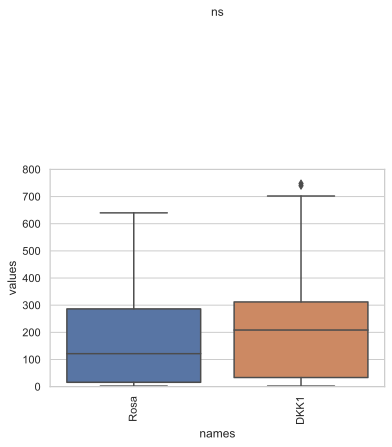

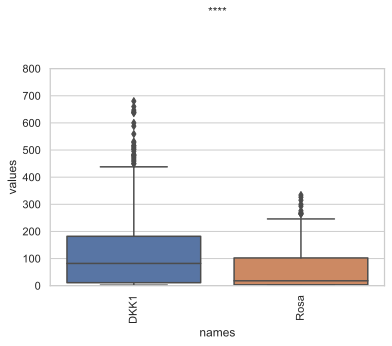

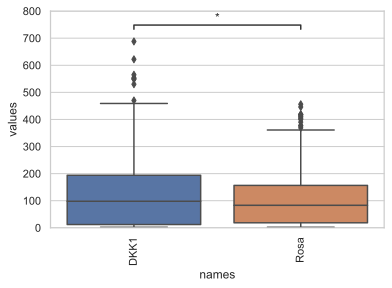

In [326]:

#Rep 1
plt.figure(1)

sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="names", y="values", data=df1)


ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
locs=ax.get_xticks()

add_stat_annotation(ax, data=df1,
                    x = "names",
                    y = "values",
                    box_pairs=[("Rosa", "DKK1")],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
plt.ylim(0,800)
output_path = "/Volumes/GoogleDrive-101945757574252901453/My Drive/Hueros_Shared/Paper/data/processed/RAR046/plots"
plt.savefig(output_path+"/box_rep1.pdf", bbox_inches='tight')


# Rep 2
plt.figure(2)
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="names", y="values", data=df2)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
locs=ax.get_xticks()


add_stat_annotation(ax, data=df2,
                    x = "names",
                    y = "values",
                    box_pairs=[("Rosa", "DKK1")],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
plt.ylim(0,800)
output_path = "/Volumes/GoogleDrive-101945757574252901453/My Drive/Hueros_Shared/Paper/data/processed/RAR046/plots"
plt.savefig(output_path+"/box_rep2.pdf", bbox_inches='tight')

#Rep 3
plt.figure(3)
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="names", y="values", data=df3)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
locs=ax.get_xticks()


add_stat_annotation(ax, data=df3,
                    x = "names",
                    y = "values",
                    box_pairs=[("Rosa", "DKK1")],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
plt.ylim(0,800)
output_path = "/Volumes/GoogleDrive-101945757574252901453/My Drive/Hueros_Shared/Paper/data/processed/RAR046/plots"
plt.savefig(output_path+"/box_rep3.pdf", bbox_inches='tight')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

DKK1 v.s. Rosa: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.171e-01 U_stat=5.350e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Rosa v.s. DKK1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.160e-02 U_stat=2.150e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Rosa v.s. DKK1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.898e-05 U_stat=1.350e+01


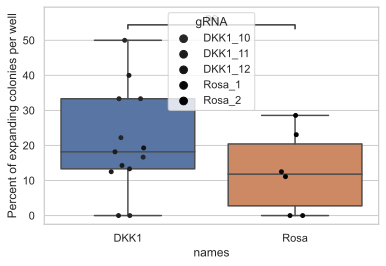

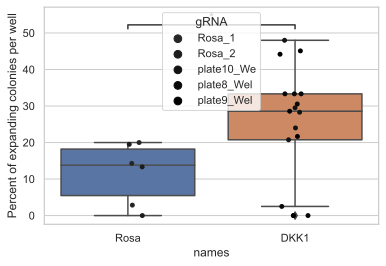

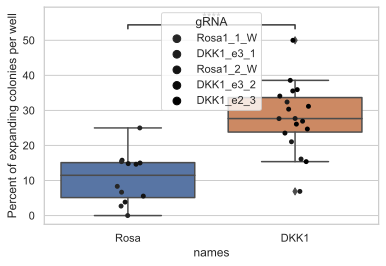

In [327]:
#Rep 1
plt.figure(1)
ax = sns.boxplot(x = "names",
            y = "Percent of expanding colonies per well",
            data = df_hist1)


ax = sns.stripplot(x = "names",
            y = "Percent of expanding colonies per well",
                    hue="gRNA",
              color = 'black',
            data = df_hist1)

add_stat_annotation(ax, data=df_hist1,
                    x = "names",
                    y = "Percent of expanding colonies per well",
                    box_pairs=[("Rosa", "DKK1")],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)


output_path = "/Volumes/GoogleDrive-101945757574252901453/My Drive/Hueros_Shared/Paper/data/processed/RAR046/plots/"
plt.savefig(output_path + "Highly_proliferative_rep1.pdf", bbox_inches='tight')

# Rep 2


plt.figure(2)
ax = sns.boxplot(x = "names",
            y = "Percent of expanding colonies per well",
            data = df_hist2)


ax = sns.stripplot(x = "names",
            y = "Percent of expanding colonies per well",
                    hue="gRNA",
              color = 'black',
            data = df_hist2)

add_stat_annotation(ax, data=df_hist2,
                    x = "names",
                    y = "Percent of expanding colonies per well",
                    box_pairs=[("Rosa", "DKK1")],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)


output_path = "/Volumes/GoogleDrive-101945757574252901453/My Drive/Hueros_Shared/Paper/data/processed/RAR046/plots/"
plt.savefig(output_path + "Highly_proliferative_rep2.pdf", bbox_inches='tight')



# Rep 2
plt.figure(3)
ax = sns.boxplot(x = "names",
            y = "Percent of expanding colonies per well",
            data = df_hist3)


ax = sns.stripplot(x = "names",
            y = "Percent of expanding colonies per well",
                    hue="gRNA",
              color = 'black',
            data = df_hist3)

add_stat_annotation(ax, data=df_hist3,
                    x = "names",
                    y = "Percent of expanding colonies per well",
                    box_pairs=[("Rosa", "DKK1")],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)


output_path = "/Volumes/GoogleDrive-101945757574252901453/My Drive/Hueros_Shared/Paper/data/processed/RAR046/plots/"
plt.savefig(output_path + "Highly_proliferative_rep3.pdf", bbox_inches='tight')
